In [1]:
import pandas as pd
import numpy as np
import math
import time
import numpy as np
# If pandas is not installed, please uncomment the following line:
#!pip install pandas
#!pip install sklearn
#!pip install pathos


In [2]:
#full

def read_mimic_csv(path):
    start = time.time()
    TextFileReader = pd.read_csv(path, chunksize=100000, iterator=True, low_memory=False)
    df = pd.concat(TextFileReader, ignore_index=True)
    print(path, ":" , round(time.time() - start, 1), 'seconds')
    return df



In [3]:
path = 'payload/full/' # change as needed
patients = read_mimic_csv(path + 'PATIENTS.csv')
diagnoses = read_mimic_csv(path + 'DIAGNOSES_ICD.csv')
admissions = read_mimic_csv(path + 'ADMISSIONS.csv')


payload/full/PATIENTS.csv : 0.1 seconds
payload/full/DIAGNOSES_ICD.csv : 0.4 seconds
payload/full/ADMISSIONS.csv : 0.3 seconds


In [4]:
ccs = open("ccs.txt", "r").read()

# Create dictionary. Key is ICD9 code for a diagnosis. Value is general description of diagnosis.
ccs = ccs[ccs.find('Tuberculosis'):]
icd9={}

def update_icd9(cur_value, section):
    while section:
        if section[:4] == '\n\n':
            print('new value')
            section = section[4:]
            cur_value = section[:section.find('\n')]
            section = section[section.find('\n'):]
        elif section[0] == ' ':
            section = section[1:]
        elif section[:2] == '\n':
            section = section[2:]
        else:
            if section.find(' ') >= 0: # not end of document
                if -1 < section.find('\n') < section.find(' '): # if end of line
                    cur_key = section[:section.find('\n')]
                else: # if not end of line
                    cur_key = section[:section.find(' ')]
                section = section[section.find(' '):]
                icd9[cur_key] = cur_value

            else: # end of section
                cur_key = section
                icd9[cur_key] = cur_value
                section = ""
            
for section in ccs.split(sep='\n\n'): # for each family of codes
    cur_value = section[:section.find('\n')] # get the name for that family
    section = section[section.find('\n')+1:] # and for all the codes under that family
    update_icd9(cur_value, section) # add those codes as keys to a dictionary, where their values
                                    # are the name for the family of codes

diagnoses.ICD9_CODE = diagnoses.ICD9_CODE.apply(lambda x: icd9.get(x,-1))

#### Create LOS feature

In [5]:
df = admissions[['SUBJECT_ID',
                 'HADM_ID',
                 'ADMISSION_TYPE',
                 'ADMITTIME']].copy()

df['LOS'] = (pd.to_datetime(admissions['DISCHTIME']) - pd.to_datetime(admissions['ADMITTIME'])).astype('timedelta64[h]') 
df['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME']) 

In [6]:
df = df[df['LOS'] >= 0]
diagnoses = pd.get_dummies(diagnoses[['HADM_ID','ICD9_CODE']], drop_first=False)
diagnoses = diagnoses.groupby('HADM_ID').agg('sum')
df = pd.merge(df, diagnoses, on='HADM_ID', how='left') 
# For mortality classification, I'm keeping DOD_HOSP so I can create a boolean response for death
# NB: DOD includes ALL deaths (before & after), while DOD_HOSP only includes deaths occuring inside the hospital. 
df = pd.merge(df, # drop DOD_HOSP too if not classifying mortality
              patients.drop(columns = ['DOD', 'DOD_SSN','ROW_ID','EXPIRE_FLAG']),
              on='SUBJECT_ID',
              how='left') 

median_dob_shift = 300 - 91.4 # For old patients (median age of 91.4), dob was shifted to be 300 yrs prior to first visit
df['AGE'] = (pd.to_datetime(df['ADMITTIME']).dt.date - pd.to_datetime(df['DOB']).dt.date)
df['AGE'] = [age.days/365 if age.days/365<300 else age.days/365-median_dob_shift for age in df['AGE']]

df['DIED'] = df['DOD_HOSP'].apply(lambda x: not pd.isnull(x))

df['ADMITHOUR_trig_x'] = pd.to_datetime(df['ADMITTIME']).dt.hour.apply(math.cos)
df['ADMITHOUR_trig_y'] = pd.to_datetime(df['ADMITTIME']).dt.hour.apply(math.sin)
df['ADMITHOUR'] = pd.to_datetime(df['ADMITTIME']).dt.hour

df.drop(['DOD_HOSP','DOB'], axis=1, inplace=True)

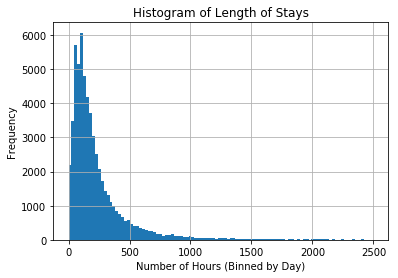

In [15]:
from matplotlib import pyplot as plt
plt.hist(df['LOS'], bins=range(int(min(df['LOS'])), 2500, 24))
plt.xlabel('Number of Hours (Binned by Day)')
plt.ylabel('Frequency')
plt.title('Histogram of Length of Stays')
plt.grid(True)
plt.show()

In [17]:
len(df['LOS'][df['LOS']>2500])/len(df['LOS'])

0.002207955433268793

In [7]:
print('Shape before adding dummy variables:',df.shape)
df = pd.get_dummies(df, drop_first=True)
print('Shape after adding dummy variables:', df.shape)

# It turns out ADMITHOUR after trig transform is highly predictive of whether you die

Shape before adding dummy variables: (58878, 293)
Shape after adding dummy variables: (58878, 295)


In [8]:
first_chartevents = read_mimic_csv('first_day_chartevents.csv')
first_chartevents = first_chartevents.drop(columns = ["Unnamed: 0"])
df = pd.merge(df, first_chartevents, on='HADM_ID',
              how='left') 

first_day_chartevents.csv : 0.2 seconds


In [9]:
# mandi's merged tables
first_serv_pres_micro = read_mimic_csv('first_serv_pres_micro.csv')
first_serv_pres_micro = first_serv_pres_micro.drop(columns = ['Unnamed: 0'])

hadm = first_serv_pres_micro.index.values
first_serv_pres_micro['HADM_ID'] = hadm

df = pd.merge(df, first_serv_pres_micro, on="HADM_ID", how = 'left')


first_serv_pres_micro.csv : 0.4 seconds


# LASSO

In [10]:
import pandas as pd
import numpy as np
import math, time
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import sklearn
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split 
from sklearn import metrics, linear_model
from sklearn.model_selection import LeaveOneGroupOut
from scipy import stats

from keras.models import Sequential
from keras.layers import Dense, Activation
%matplotlib inline
#import d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils

Using TensorFlow backend.


In [12]:
df_demo = df
df_demo.drop([col for col, val in df_demo.sum().iteritems() if type(val) == int and val < 2], axis=1, inplace=True)
df_demo.shape

df_demo = df_demo.drop(columns = ["SUBJECT_ID","ADMITTIME"])
df_demo = df_demo.fillna(0)


X = df_demo.iloc[:,2:].drop('DIED',axis=1)
y = df_demo['DIED']
X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(X, y, test_size=0.2, random_state=0)  

In [13]:
time1 = time.time()

#alphas = np.array([-1, -0.1 , 0.01, 0.1, 1, 10 , 100])
alphas = np.array([-1, 1, 10])

lassocv = linear_model.LassoCV(cv = 5, normalize=True)
lassocv.fit(X, y)
lassocv_score = lassocv.score(X, y)
lassocv_alpha = lassocv.alpha_

time.time() - time1

8.384374141693115

In [14]:
time1 = time.time()

lasso = Lasso(alpha = lassocv_alpha)#, max_iter = 10e6)
lasso.fit(X_train_demo, y_train_demo)
train_score = lasso.score(X_train_demo, y_train_demo)
test_score = lasso.score(X_test_demo, y_test_demo)
coef_used = np.sum(lasso.coef_ != 0)

print('training score: ', train_score)
print('test score: ', test_score)
print('number of features used: ', coef_used)

time.time() - time1

training score:  0.27934352316594024
test score:  0.2717367656523436
number of features used:  285


11.032665729522705

In [15]:
zeros = []

used = []

for i in range(len(lasso.coef_ )):
    if lasso.coef_[i] == 0:
        zeros += [i]
    else:
        used += [i]

#test to see what it looks like:
#X.iloc[0:10, used]

In [16]:
filtered = X.iloc[:, used]
filtered['DIED'] = y

/home/ubuntu/miniconda3/envs/gluon/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
from sklearn.neural_network import MLPClassifier

In [24]:
X = filtered.drop(columns = ['DIED'])
y = filtered['DIED']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

In [46]:
time1 = time.time()

mlp_LR = MLPClassifier(solver='lbfgs', beta_1=0.9, beta_2=0.999, 
                       alpha=1e-5, batch_size = 256,
                       activation = 'relu', momentum = 0.99,
                       warm_start=True, shuffle = True,
                       learning_rate_init = 0.00001, 
                       power_t = 0.5, early_stopping = False,
                       epsilon = 1e-08, n_iter_no_change = 10,
                       nesterovs_momentum = True,
                       hidden_layer_sizes=(256, 128), 
                       tol = 0.001, max_iter = 200,
                       random_state=1, verbose = False)
mlp_LR.fit(X_train, y_train)

time.time() - time1


168.56042981147766

In [47]:
lr_predictions = mlp_LR.predict(X_test)

# ACCURACY

In [48]:
sum(lr_predictions == y_test) / len(y_test)

0.7870244565217391

In [ ]:
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False,
              epsilon=1e-08, hidden_layer_sizes=(5, 2),
              learning_rate='constant', learning_rate_init=0.001,
              max_iter=200, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=1,
              shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [30]:
import pandas as pd
import numpy as np
import math, time
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from scipy import stats

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization

In [31]:
# If pandas is not installed, please uncomment the following line:
#!pip install pandas
#!pip install sklearn


In [32]:
bert = pd.read_pickle('bert.pkl')

In [33]:
bert_df = pd.merge(df_demo, bert, on='HADM_ID',
              how='left') 

In [34]:
bert_df['VEC'] = bert_df['VEC'].apply(lambda d: d if isinstance(d, np.ndarray) else [[0]]*768)
bert_df = pd.merge(bert_df.iloc[:,:-1], 
                   pd.DataFrame(bert_df.VEC.values.tolist(), index= bert_df.HADM_ID).applymap(lambda x: x[0]),
                   on='HADM_ID',
                   how='inner')

In [35]:
#post lasso data
#filtered = pd.read_csv('filtered.csv') 
filtered = pd.concat([bert_df.iloc[:,used], bert_df.iloc[:,-768:]], axis=1)


In [36]:
# if when u run lasso, there are different number of features,
# just put labels as last column below.
X = filtered.drop(columns = ['LOS','DIED','HADM_ID'])
y = filtered['DIED']

### Linear Regression 

In [37]:
from sklearn.linear_model import LinearRegression, RidgeCV, LogisticRegressionCV
from sklearn.metrics import mean_squared_error

#### Logistic Regression: baseline

In [38]:
y = filtered['DIED']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

In [39]:
log = LogisticRegressionCV(Cs=[.01,.1,1,10], fit_intercept=True, cv=5, random_state=0).fit(X_train,y_train)
log.score(X_train,y_train)

0.7461891214810411

In [40]:
log.score(X_test,y_test)

0.7426120923913043

In [41]:
1 - sum(y)/len(y)

0.745473691361799